# Assignment 5

This assignment has weighting $1.5$.

# Model tuning and evaluation

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions


In [2]:
import pandas as pd

wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
#wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [4]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

## Answer

We should use k-fold to valid the whole pipeline rather than the perceptron itself. 
Moreover, we should use `fit` rather than `partial_fit`, because each fold should be independent. 

I have deleted the epoch, because in my understanding, epoch means use the same data to train the the same model multiple times, however, that is not suitable in K-fold validation. (Moreover, even we want to mimic epoch in training, pipeline have no partial fit either). 


In [6]:
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

scl = StandardScaler()
pca = PCA(n_components=2)
clf = Perceptron(random_state=1)

pipe_lr = Pipeline([('scl', scl),
                    ('pca', pca),
                    ('clf', clf)])


# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

scores = []

enumerate_kfold = list(enumerate(kfold))
for k, (train, test) in enumerate_kfold:
    pipe_lr.fit(X_train_std[train], y_train[train])
    score = pipe_lr.score(X_train_std[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k,
                                                               np.bincount(y_train[train]),
                                                               score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 0, Class dist.: [256 153], Acc: 0.783
Fold: 1, Class dist.: [256 153], Acc: 0.717
Fold: 2, Class dist.: [256 153], Acc: 0.739
Fold: 3, Class dist.: [256 153], Acc: 0.674
Fold: 4, Class dist.: [256 153], Acc: 0.870
Fold: 5, Class dist.: [257 153], Acc: 1.000
Fold: 6, Class dist.: [257 153], Acc: 0.956
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.978
Fold: 9, Class dist.: [257 153], Acc: 0.978

CV accuracy: 0.863 +/- 0.117


# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

In [7]:
# your code
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import RandomizedSearchCV
else:
    from sklearn.model_selection import RandomizedSearchCV
    
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix



pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[71  1]
 [ 2 40]]


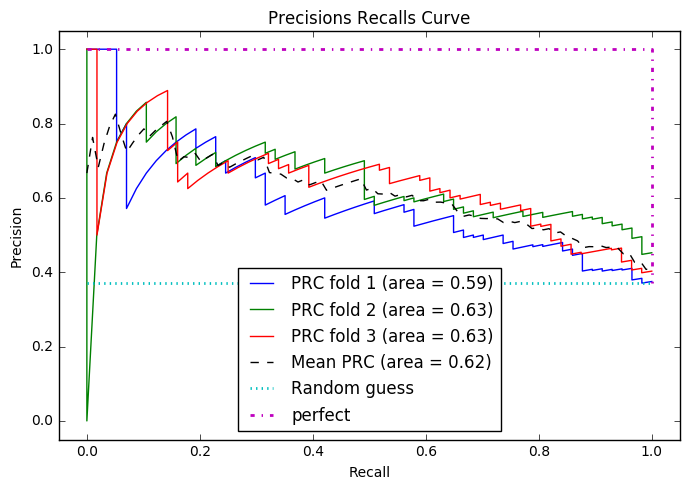

In [8]:
import matplotlib.pyplot as plt 


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve as pr_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from scipy import interp
import collections
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

# intentionally use only 2 features to make the task harder and the curves more interesting
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]

if Version(sklearn_version) < '0.18':
    cv = StratifiedKFold(y_train, 
                         n_folds=3, 
                         random_state=1)
    
else:
    cv = list(StratifiedKFold(n_splits=3, 
                              random_state=1).split(X_train, y_train))

    
    
fig = plt.figure(figsize=(7, 5))



mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)


for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    #
    precisions, recalls, thresholds = pr_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    
    mean_precision  += interp(mean_recall, recalls[::-1], precisions[::-1])
    #print(recalls)
    #print(interp(mean_recall, recalls[::-1], precisions[::-1]))
    #print(mean_precision)
    area = auc(recalls, precisions)
   
    plt.plot(recalls,
             precisions,
             lw=1,
             label='PRC fold %d (area = %0.2f)'
                   % (i+1, area))



    
c = collections.Counter(y_train[test])    
True_rate = c[1]/(c[0]+c[1]) # the rate of positive in the data 

mean_precision /= len(cv) 

area = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--', label= "Mean PRC (area = %0.2f)"
                   % (area))

plt.plot([0.0, 1.0],[True_rate, True_rate], lw=2, linestyle=':', label="Random guess")
plt.plot([0.0, 1.0, 1.0], [1.0, 1.0, True_rate], lw=2, linestyle='-.', label="perfect")




plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precisions Recalls Curve')
plt.legend(loc="best")


plt.tight_layout()
plt.show()


## your explanation

#### 1
Actually PRC has a baseline and ROC has not. PRC will care about the distribution of 1s and 0s in truth while ROC not. 

#### 2
The area under curve both shows the performance of the classifier, but they are emphasizing on different areas. 

#### 3
ROC curve mesaures between Sensitivity (True Postive) and Sepcificity (1 - False Positive) .  
PRC curve measures between Precision and Recall. 

Actually Sensitivity is the same as Recall. However, Specificity is different from Precision.

$Precision=\frac{TP}{TP+FP}$ measures the rate of an object is 1 if you said it is 1. 


$Specificity = \frac{TN}{N}$ measures the rate of 0s to be identified of all the 0s. 


PRC is much better if the porpotion of 1 is very small. 





# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [9]:
from scipy.misc import comb
import math
import numpy as np

def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [12]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [13]:

print(ensemble_error(num_classifier=num_classifier, base_error=base_error))


0.034327507019


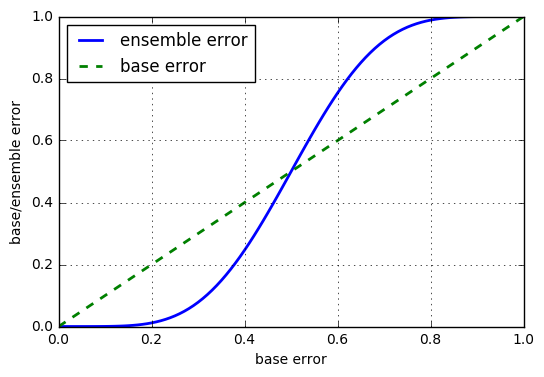

In [14]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensembe error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [15]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):
    # your code here
    ensemble_errors=[]
    for num_classifier in range(1, max_num_classifier+1):
        err = ensemble_error_func(num_classifier,  base_error)
        ensemble_errors.append(err)
    
    
    numbers = np.arange(1, max_num_classifier+1)
    plt.plot(numbers, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.xlabel('number of classifiers')
    plt.ylabel('ensember error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

State your observations of the experiments of your code...

In [16]:
max_num_classifiers = 20
base_error = 0.25

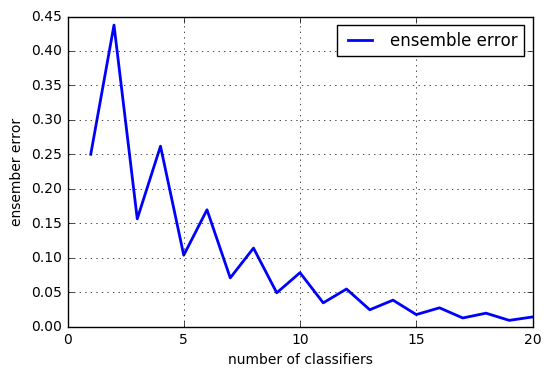

In [17]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

Explain your observations above.
## Answer

Actually the ensemble error rate fluctuates. 

That is actually because the assumption that the ensemble classifier is error when **at least half** is error. However, when there is a **tie**, it regard the ensemble as error directly. 

For example, if we have 6 classifier, 3 correct, 3 wrong, then it assume that it is wrong. So the error rate is actually larger than 5. 


One solution is that, when there is a tie, we count it at 50 percent wrong. 

Describe a better algorithm for computing the ensemble error.

In [18]:
def better_ensemble_error(num_classifier, base_error):
    # replace the following default line with your implementation of a better algorithm for ensemble error
    
    
    k_start = math.floor(num_classifier/2)+1
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    if num_classifier%2 == 0:
        k = num_classifier / 2 
        probs.append(0.5* comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)))
    #print(probs)
    
    return sum(probs)

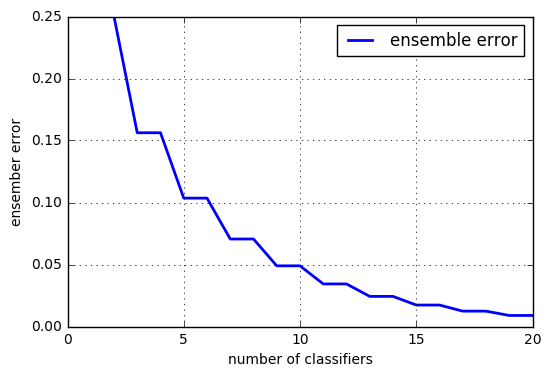

In [19]:
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)
#print(ensemble_error(2, 0.25))